In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.layers import Dropout, Flatten
from tensorflow.keras.layers import Conv2D , MaxPooling2D
import cv2
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import random
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [2]:
path = "Train"
labelFile = 'Train.csv'
count = 0
images = []
label = []
batch_size_val=16
steps_per_epoch_val=40
epochs_val=40

Total Classes: 43
Importing Classes.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  
Data Shapes
Train(25093, 32, 32, 3) (25093,)
Validation(6274, 32, 32, 3) (6274,)
Test(7842, 32, 32, 3) (7842,)
data shape  (39209, 8) <class 'pandas.core.frame.DataFrame'>
[124, 1416, 1448, 935, 1307, 1197, 272, 919, 901, 931, 1294, 841, 1374, 1310, 502, 405, 279, 678, 777, 133, 245, 217, 257, 317, 163, 974, 374, 162, 355, 163, 295, 462, 157, 435, 261, 758, 264, 147, 1338, 195, 221, 144, 146]


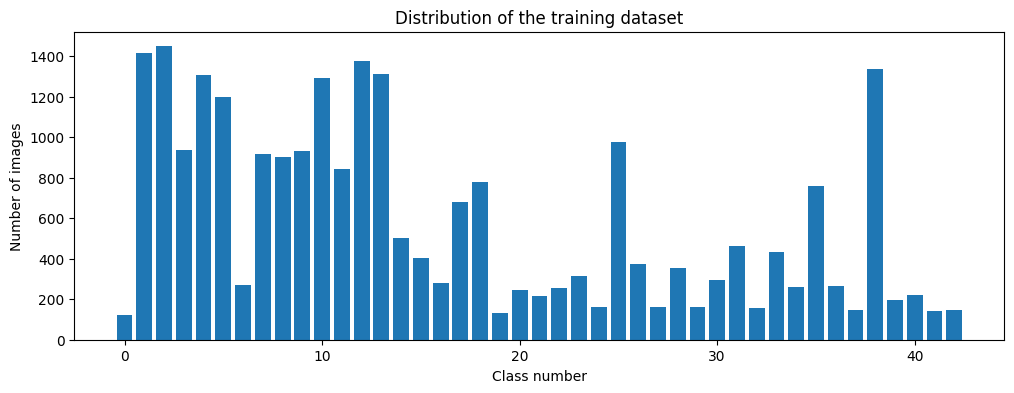

In [3]:
classes_list = os.listdir(path)
print("Total Classes:",len(classes_list))
noOfClasses=len(classes_list)
print("Importing Classes.....")
for x in range (0,len(classes_list)):
    imglist = os.listdir(path+"/"+str(count))
    for y in imglist:
        img = cv2.imread(path+"/"+str(count)+"/"+y)
        img =cv2.resize(img,(32,32))
        images.append(img)
        label.append(count)
    print(count, end =" ")
    count +=1
print(" ")
images = np.array(images)
classNo = np.array(label)
data=np.array(images)
data= np.array(data).reshape(-1, 32, 32, 3)

X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=0.2)
Y_tests=y_test
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

print("Data Shapes")
print("Train",end = "");print(X_train.shape,y_train.shape)
print("Validation",end = "");print(X_validation.shape,y_validation.shape)
print("Test",end = "");print(X_test.shape,y_test.shape)
data=pd.read_csv(labelFile)
print("data shape ",data.shape,type(data))
num_of_samples = []
cols = 3
num_classes = noOfClasses
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(30, 300))
fig.tight_layout()
for i in range(cols):
    for j,row in data.iterrows():
        x_selected = X_train[y_train == j]
        if len(x_selected)==0:
            continue
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected)-1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j)+ "-"+str(row["ClassId"]))
            num_of_samples.append(len(x_selected))

print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()


In [4]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

In [5]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

In [6]:
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img / 255 # image normalization
    return img

In [7]:
X_train = np.array(list(map(preprocessing, X_train)))
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))

In [8]:
### reshape data into channel 1
X_train=X_train.reshape(-1,32,32,1)
X_validation=X_validation.reshape(-1,32,32,1)
X_test=X_test.reshape(-1,32,32,1)

In [9]:
#Augmentation of  images
dataGen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)
dataGen.fit(X_train)
batches = dataGen.flow(X_train, y_train,batch_size=20)
X_batch, y_batch = next(batches)
y_train = to_categorical(y_train, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)

In [76]:
# CNN Model
def seq_Model():
    no_Of_Filters = 60
    size_of_Filter = (5, 5)
    size_of_Filter2 = (3, 3)
    size_of_pool = (2, 2)
    no_Of_Nodes = 500
    model = Sequential()
    model.add((Conv2D(no_Of_Filters, size_of_Filter, input_shape=(32, 32, 1),
                      activation='relu')))
    model.add((Conv2D(no_Of_Filters, size_of_Filter, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))

    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(no_Of_Nodes, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses, activation='softmax'))
    model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


model = seq_Model()
print(model.summary())
'''model = myModel()
print(model.summary())
my_callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]'''

history=model.fit(dataGen.flow(X_train,y_train,batch_size=batch_size_val),steps_per_epoch=steps_per_epoch_val,
                  epochs=epochs_val,validation_data=(X_validation,y_validation),shuffle=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 476, 636, 60)      1560      
                                                                 
 conv2d_9 (Conv2D)           (None, 472, 632, 60)      90060     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 236, 316, 60)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 234, 314, 30)      16230     
                                                                 
 conv2d_11 (Conv2D)          (None, 232, 312, 30)      8130      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 116, 156, 30)      0         
 g2D)                                                 

InvalidArgumentError: Graph execution error:

Detected at node sequential_2/dense_4/Relu defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "d:\env\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "d:\env\Lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance

  File "d:\env\Lib\site-packages\ipykernel\kernelapp.py", line 736, in start

  File "d:\env\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\OUAZZE\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\OUAZZE\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\OUAZZE\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run

  File "d:\env\Lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue

  File "d:\env\Lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one

  File "d:\env\Lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell

  File "d:\env\Lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request

  File "d:\env\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "d:\env\Lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell

  File "d:\env\Lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "d:\env\Lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "d:\env\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "d:\env\Lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "d:\env\Lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "d:\env\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\OUAZZE\AppData\Local\Temp\ipykernel_1560\1857092065.py", line 37, in <module>

  File "d:\env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "d:\env\Lib\site-packages\keras\src\engine\training.py", line 1783, in fit

  File "d:\env\Lib\site-packages\keras\src\engine\training.py", line 1377, in train_function

  File "d:\env\Lib\site-packages\keras\src\engine\training.py", line 1360, in step_function

  File "d:\env\Lib\site-packages\keras\src\engine\training.py", line 1349, in run_step

  File "d:\env\Lib\site-packages\keras\src\engine\training.py", line 1126, in train_step

  File "d:\env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "d:\env\Lib\site-packages\keras\src\engine\training.py", line 589, in __call__

  File "d:\env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "d:\env\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "d:\env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "d:\env\Lib\site-packages\keras\src\engine\sequential.py", line 398, in call

  File "d:\env\Lib\site-packages\keras\src\engine\functional.py", line 515, in call

  File "d:\env\Lib\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "d:\env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "d:\env\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "d:\env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "d:\env\Lib\site-packages\keras\src\layers\core\dense.py", line 255, in call

  File "d:\env\Lib\site-packages\keras\src\activations.py", line 306, in relu

  File "d:\env\Lib\site-packages\keras\src\backend.py", line 5397, in relu

Matrix size-incompatible: In[0]: [16,480], In[1]: [542880,500]
	 [[{{node sequential_2/dense_4/Relu}}]] [Op:__inference_train_function_52736]

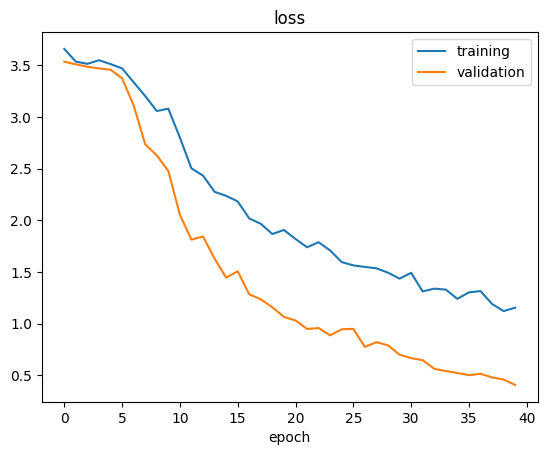

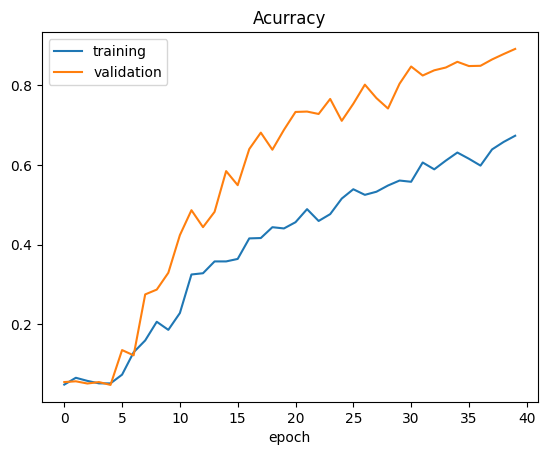

246/246 - 11s - loss: 0.4131 - accuracy: 0.8894 - 11s/epoch - 44ms/step


d:\env\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: Mymodel\assets


INFO:tensorflow:Assets written to: Mymodel\assets


In [42]:
##Plot Graph##
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()

score =model.evaluate(X_test,y_test,verbose=2)
'''print('Test Score:',score[0])
print('Test Accuracy:',score[1])'''

model.save("myModel.h5")
model.save("Mymodel")
model.save_weights("weights.h5")

## Test Ve

In [43]:
import numpy as np
import cv2
import pickle
import os

In [44]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [45]:
frameWidth = 640
frameHeight = 480
brightness = 180
threshold = 0.90
font = cv2.FONT_HERSHEY_SIMPLEX

In [64]:
cap = cv2.VideoCapture("http://192.168.1.2:8080//video")
cap.set(3, frameWidth)
cap.set(4, frameHeight)
cap.set(10, brightness)

False

In [56]:
from keras.models import load_model

In [57]:
model = load_model("myModel.h5")

In [58]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

In [59]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

In [60]:
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img / 255
    return img

In [77]:
def getCalssName(classNo):
    if classNo == 0:return 'Speed Limit 20 km/h'
    elif classNo == 1:return 'Speed Limit 30 km/h'
    elif classNo == 2:return 'Speed Limit 50 km/h'
    elif classNo == 3: return 'Speed Limit 60 km/h'
    elif classNo == 4: return 'Speed Limit 70 km/h'
    elif classNo == 5:return 'Speed Limit 80 km/h'
    elif classNo == 6:return 'End of Speed Limit 80 km/h'
    elif classNo == 7:return 'Speed Limit 100 km/h'
    elif classNo == 8:return 'Speed Limit 120 km/h'
    elif classNo == 9:return 'No passing'
    elif classNo == 10:return 'No passing for vechiles over 3.5 metric tons'
    elif classNo == 11:return 'Right-of-way at the next intersection'
    elif classNo == 12:return 'Priority road'
    elif classNo == 13:return 'Yield'
    elif classNo == 14:return 'Stop'
    elif classNo == 15:return 'No vechiles'
    elif classNo == 16:return 'Vechiles over 3.5 metric tons prohibited'
    elif classNo == 17:return 'No entry'
    elif classNo == 18:return 'General caution'
    elif classNo == 19:return 'Dangerous curve to the left'
    elif classNo == 20:return 'Dangerous curve to the right'
    elif classNo == 21:return 'Double curve'
    elif classNo == 22:return 'Bumpy road'
    elif classNo == 23:return 'Slippery road'
    elif classNo == 24:return 'Road narrows on the right'
    elif classNo == 25:return 'Road work'
    elif classNo == 26:return 'Traffic signals'
    elif classNo == 27:return 'Pedestrians'
    elif classNo == 28:return 'Children crossing'
    elif classNo == 29:return 'Bicycles crossing'
    elif classNo == 30:return 'Beware of ice/snow'
    elif classNo == 31:return 'Wild animals crossing'
    elif classNo == 32:return 'End of all speed and passing limits'
    elif classNo == 33:return 'Turn right ahead'
    elif classNo == 34:return 'Turn left ahead'
    elif classNo == 35:return 'Ahead only'
    elif classNo == 36:return 'Go straight or right'
    elif classNo == 37:return 'Go straight or left'
    elif classNo == 38:return 'Keep right'
    elif classNo == 39:return 'Keep left'
    elif classNo == 40:return 'Roundabout mandatory'
    elif classNo == 41:return 'End of no passing'
    elif classNo == 42:return 'End of no passing by vechiles over 3.5 metric tons'

    while True:

        succes, imgOrignal =cap.read()

        img = np.asarray(imgOrignal)
        img = cv2.resize(img,(32, 32, 1))
        img = preprocessing(img)
        cv2.imshow("Processed Image", img)
        img = img.reshape(1,32,32,1)
        cv2.putText(imgOrignal, "CLASS: ", (20, 35), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
        cv2.putText(imgOrignal, "PROBABILITY:", (20, 75), font, 0.75, (255, 0, 0), 2, cv2.LINE_AA)
        predictions = model.predict(img)  # make predicion
        classIndex = model.predict_classes(img)
        probabilityValue = np.amax(predictions)
        if probabilityValue > threshold:
            # write class name on the output screen
            cv2.putText(imgOrignal, str(classIndex) + " " + str(getCalssName(classIndex)),(120,35),font,0.75,(0,0,255),2,cv2.LINE_AA)
            # write probability value on the output screen
            cv2.putText(imgOrignal, str(round(probabilityValue * 100, 2)) + "%", (180, 75), font, 0.75, (255, 0, 0), 2, cv2.LINE_AA)

        cv2.imshow("Result", imgOrignal)
        if cv2.waitKey(1) & 0xFF == ord('q'):  # q for quit
            break

In [97]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame.reshape(480, 640, 3)
    
    # Make detections 
    results = model(frame)
    
    cv2.imshow('YOLO', np.squeeze(results.render()))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 480, 640, 1), found shape=(480, 640, 3)

In [100]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    
    # Resize the image to (480, 640)
    resized_data = cv2.resize(frame, (640, 480))

    # Reshape the image to (480, 640, 1)
    reshaped_data = np.expand_dims(resized_data, axis=1)

    # Now 'reshaped_data' has the shape (480, 640, 1) and is ready to be used as input to your model 
    # Make detections 
    results = model(reshaped_data)
    
    cv2.imshow('YOLO', np.squeeze(results.render()))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()



ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 480, 640, 1), found shape=(480, 640, 3, 1)